# Poleward Heat Transport

`mom6_tools.polar_heat_transport` collection of functions for computing and plotting poleward heat transport.

The goal of this notebook is the following:

1) server as an example on to compute polar heat transport from CESM/MOM output; 

2) evaluate model experiments by comparing transports against observed estimates;

3) compare model results vs. another model results (TODO).

In [2]:
%matplotlib inline
from mom6_tools.poleward_heat_transport import  *
from mom6_tools.m6toolbox import check_time_interval, genBasinMasks
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

In [3]:
# The following parameters must be set accordingly
######################################################
# case name - must be changed for each configuration
case_name = 'g.c2b6.GNYF.T62_t061.long_mct_RASM1.002'
# Path to the run directory
path = "/glade/scratch/gmarques/"+case_name+"/run/"
# initial and final years for computing time mean
year_start = 1
year_end = 60
# add your name and email address below
author = 'Gustavo Marques (gmarques@ucar.edu)'
######################################################
# create an empty class object
class args:
  pass

args.infile = path
args.static = case_name+'.mom6.static.nc'
args.monthly = case_name+'.mom6.hm_*nc'
args.year_start = year_start
args.year_end = year_end
args.case_name = case_name
args.label = ''
args.savefigs = False

MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]


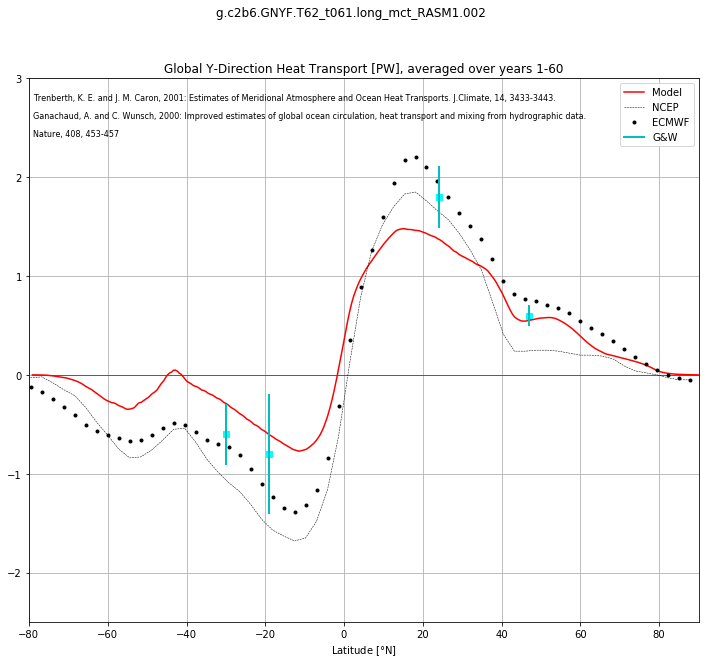

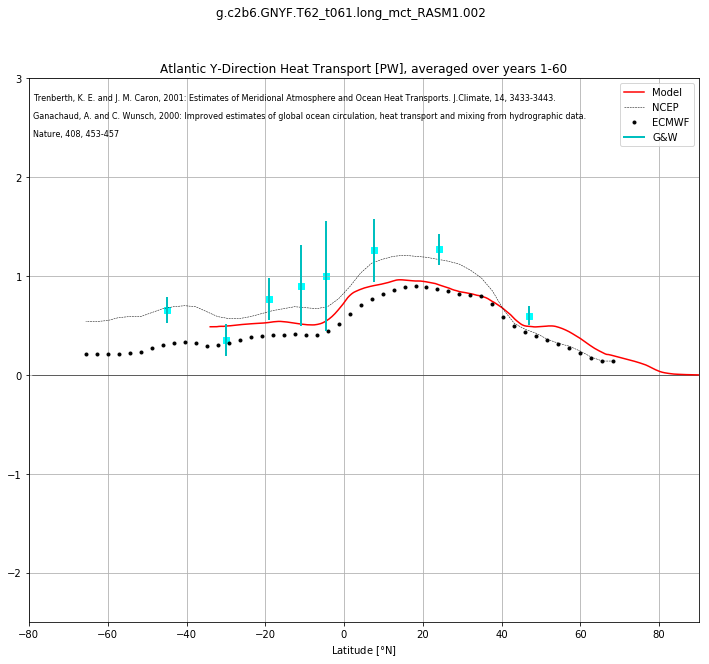

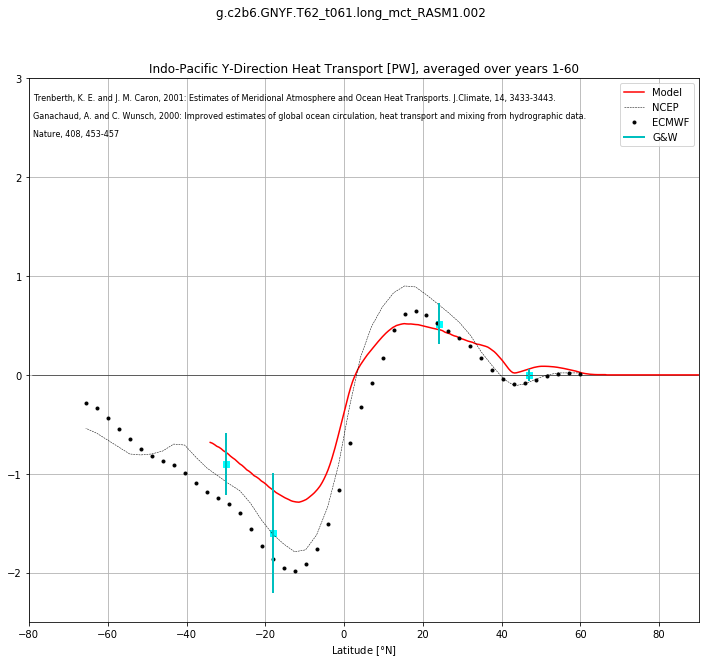

In [4]:
stream = True
grd = MOM6grid(args.infile+args.static)
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
#basin_code = netCDF4.Dataset('/glade/scratch/gmarques/g.c2b6.GNYF.T62_t061.long_30m.001/run/INPUT/basin.nc').variables['basin'][:]
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, verbose=False)
# load data
ds = xr.open_mfdataset(args.infile+args.monthly,decode_times=False)
# convert time in years
ds['time'] = ds.time/365.
ti = args.year_start
tf = args.year_end
# check if data includes years between ti and tf
check_time_interval(ti,tf,ds)

# create a ndarray subclass
class C(np.ndarray): pass

varName = 'T_ady_2d'
if varName in ds.variables:
  tmp = np.ma.masked_invalid(ds[varName].sel(time=slice(ti,tf)).mean('time').data)
  tmp = tmp[:].filled(0.)
  advective = tmp.view(C)
  advective.units = ds[varName].units
else:
  raise Exception('Could not find "T_ady_2d" in file "%s"'%(args.infile+args.monthly))

varName = 'T_diffy_2d'
if varName in ds.variables:
  tmp = np.ma.masked_invalid(ds[varName].sel(time=slice(ti,tf)).mean('time').data)
  tmp = tmp[:].filled(0.)
  diffusive = tmp.view(C)
  diffusive.units = ds[varName].units
else:
  diffusive = None
  warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

# plot model vs obs
plt_heat_transport_model_vs_obs(advective, diffusive, basin_code, grd, args)  